In [3]:
%load_ext autoreload
%autoreload 2
!pip install -r requirements.txt

import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import clear_output, Image


import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
import warnings
warnings.filterwarnings("ignore")

from envs.bandit import Bandit
from envs.context_bandit import ContextualBandit, get_state_probs
from envs.frozen_lake import FrozenLakeEnv

from utils import *
from value_iteration import *
from mcts import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# The Bitter Lesson

Rich Sutton, one of the pioneers of modern reinforcement learning, detailed an account of the ["Bitter Lesson"](http://www.incompleteideas.net/IncIdeas/BitterLesson.html) of machine learning. 
               
In short, he speaks of the power of computation-driven learning. Over the almost 100 years of serious AI research that has happened so much effort has been put into distilling human knowledge down to core concepts or primitives that we can give to machines to make them intelligent. Time and time again, the biggest breakthoughs in ML/AI have not been in perfect representations of knowledge or heuristics about how to learn, but in leveraging computation resources available to allow these software agents to discover the structure in the problems themselves.

## Learning without Knowledge

The purpose of this session is to show some techiques we have under our belt to tackles problems without incorporating knowledge of the process we want to learn. While using heuristics or priors can great speed up learning on certain problems, we want to show in general we can learn in the most efficient way possible without any of that.

We will structure this post into 3 parts:

* Stateless, only your actions yield outcomes across independent trails
* Stateful, your actions yield outcomes in a context across independent trials
* Stateful, your actions yield outcomes in a context over time

This allows us to tackle problems with minimum information about the world first, see how we would solve them, and then modify our policies when we have more information to take advantage.


## Part 1: Bandits



![Bandit](assets/multi_armed_bandit.png)

A bandit problem refers to an environment where only the agents actions will effect the reward they recieve. The example above shows that each action (the arm to pull) has a certain distribution of rewards that can result. The job of the agent is to find out as quickly as possible which action is the best. 

What does "best" mean in this context? The metric that is used is called the **Regret**.

### Regret

It is defined as the expected reward an agent lost out on by not choosing the optimal action. To put a bit of terminology to this, we can define the expected reward of an action as $Q(a_i) = E[r | a]$, also called the **Value Function**. If we assume that the bandit arms will give rewards according to a bernoulli random variable $r(a_i) \sim bern(\theta_i)$. Then the regret can be written as:

$$
R(t) = \sum_{t = 0}^T (\theta_* - Q(a_t))
$$

For example, consider a 2-armed bandit with pull probabilities $(0.3, 0.8)$. The optimal action is to choose the second arm always, $\theta_* = 0.8$. We can compare to action sequences using the regret. Imagine action sequence 1:  $[0, 1, 1, 1, 0, 0]$ and action sequence 2: $[0, 0, 0, 0, 1, 1]$. The regret they accrue can be computed with the above formula:

$$
R_1(t) = (0.8 - 0.3) + (0.8 - 0.8) + (0.8 - 0.8) + (0.8 - 0.8) + (0.8 - 0.3) + (0.8 - 0.3) = 1.5 \\
R_2(t) = (0.8 - 0.3) + (0.8 - 0.3) + (0.8 - 0.3) + (0.8 - 0.3) + (0.8 - 0.8) + (0.8 - 0.8) = 2
$$

So the policy that generated the first sequence has the least regret. We seek to find policies with the smallest expected regret.

In [ ]:
"""
Let's play around with a bandit to see what the problem is like. You can change any of the variables below
to modify how many arms there are or the likelihoods of arms giving reward. Once you run this cell, you will be 
able to interact with some buttons to produce plots on how well you are doing.
"""
n_arms = 8

# Setup some random arm probabilities
bad_arm_prob = 0.3
good_arm_prob = 0.8
regret = good_arm_prob - bad_arm_prob
probs = np.zeros(n_arms) + bad_arm_prob
probs[np.random.choice(range(n_arms))] = good_arm_prob

# Configure environment
config = {"num_arms" : n_arms, "probs": probs}
env = Bandit(config)

# Create fancy UI
buttons = [widgets.Button(description=f'Arm: {i}') for i in range(n_arms)]
cumulative_reward = [0]
def press(button):
    ## Sanitize inputs, clear current output
    clear_output()
    value = int(button.description.split(" ")[1])
    
    ## Step env, keep track of cumulative reward each step
    r = env.step(value)
    cumulative_reward.append(env.cumulative_reward.sum())
    print(f"Reward: {r}, Total steps: {env.visits.sum()}")
    
    ## plot
    fig, axs = plt.subplots(1, 3, figsize=(15, 8))
    plot_avg_reward(axs[0], env)
    plot_cumulative_reward(axs[1], cumulative_reward)
    plot_cumulative_regret(axs[2], regret, env)

    plt.legend()
    fig.tight_layout()
    
    display(buttons)

[buttons[i].on_click(press) for i in range(n_arms)]
buttons = widgets.HBox(buttons)
display(buttons)

## Solving bandit problems

As we can see in the regret formula, the most important parameter to estimate is the true average reward an arm will yield.  
Without any model of how the reward-generating process works, the agent needs to collect information and construct an estimate of the arm averages. 

**Exploration** and **Exploitation** describes the tradeoff an agent makes while it is trying to make these decisions online. The strategies we will investigate different combinations of how to make decisions under uncertainty:
- random exploration
- minimal exploration, just greedily pull best values we have seen in past
- explore with preference towards uncertainty

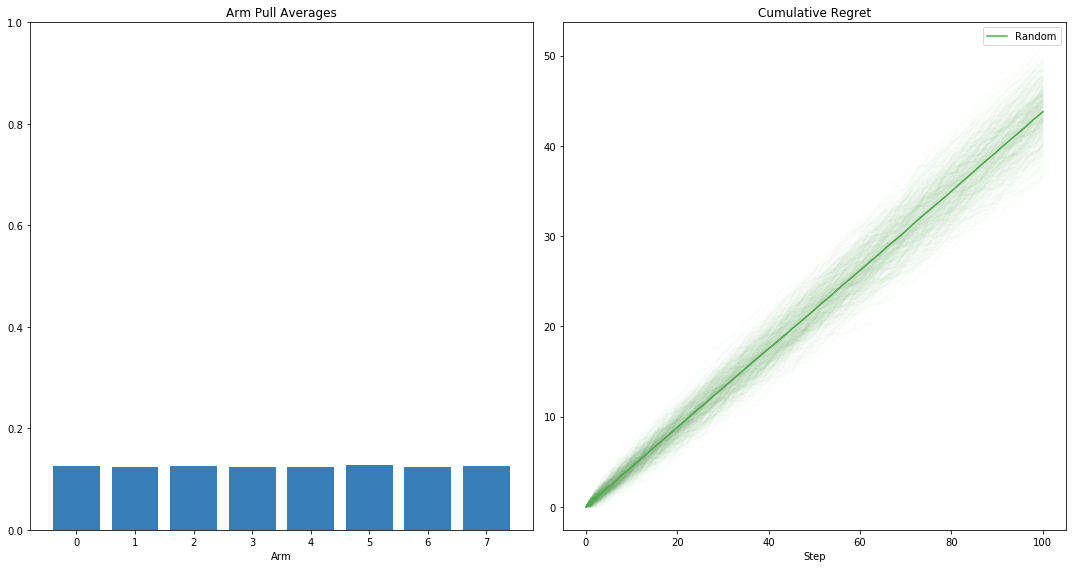

In [28]:
"""
Pure random exploration will investigate each action with equal likelihood, but never exploits that knowledge to improve its regret.
"""

# Run 500 trials of 100 step bandit interactions
n_steps = 100
n_trials = 500
n_arms = 8

# Arm probabilities bias the 
config = {"num_arms" : n_arms, "probs": (1/n_arms) * np.arange(n_arms)}
env = Bandit(config)

def random_selection(env):
    return np.random.randint(env.n_arms)

random = run_simulation(random_selection, env, n_steps=n_steps, n_trials=n_trials)
plot_simulation([random[1]], random[0], env)
plt.show()

In [30]:
"""
The epsilon greedy action selection algorithm uses the same ideas from random exploration, 
but ensures we exploit that information some fraction of the time. 

Several variations of this algorithm can be constructed, such as using an annealing schedule to drop the
epsilon value over time when we believe our arm average estimates are trustworthy to more greedily apply.
"""
def e_greedy_selection(env, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(env.n_arms)
    else:
        return np.argmax(env.arm_avgs())
def create_egreedy(epsilon):
    "Helper method to return a handle for different epsilon values"
    return lambda env: e_greedy_selection(env, epsilon)
def update(epsilon):
    global egreedy
    selection = create_egreedy(epsilon)
    egreedy = run_simulation(selection, env, n_steps=n_steps, n_trials=n_trials)
    plot_simulation([random[1], egreedy[1]], egreedy[0], env)
    plt.show()

# Allows you to interact with different epsilon values and see their effect on solutions relative to the previous random policy
interact_manual(update, epsilon=widgets.FloatSlider(min=0, max=1, step=0.05))

interactive(children=(FloatSlider(value=0.0, description='epsilon', max=1.0, step=0.05), Button(description='R…

<function __main__.update(epsilon)>

### UCB Algorithm

$\epsilon$-Greedy works well for a lot of problems, but requires tuning of the hyperparameter is not really principled in any sort of way. This makes it difficult to say anything about the theoretical guarantees of the algorithm. Using some simple arguments about probability bounds, we can find better tradeoffs of exploitation and exploration.

The idea is to agument the value function with an upper bound on the reward value so that the true reward value is lower: $Q(a) \leq \hat{Q}_t(a) + \hat{U}_t(a)$. Hoeffding's inequality can be used if we do not want to assign any prior to the distribution of rewards, works for any bounded distribution. 

$$P[\frac{1}{n} \sum_{i =1}^{n}(Z_i - E[Z_i]) \geq \Delta\ ] \leq e^{- \frac{2n\Delta^2}{(b - a)^2}}$$

So we view this average of the random variable $Z_i$ as the averaged reward of a particular action, $\hat{Q_t}(a) = \frac{1}{n} \sum_{t=0}^n R_i$. The inequality then gets written as (with $t = N_t(a)$, the number of times this action has been visited): 

$$P[Q_t - \hat{Q_t} \geq \Delta ] \leq e^{-\frac{2N_t(a)\delta^2}{(b-a)^2}}$$

We see that then our upper bound on the true reward can be given by $\delta = \hat{U_t}(a)$. And if we make the simplifying assumption that the reward is bounded to be on the interval $(0, 1)$. We can then for any value of the probability of deviation, $p$, we can solve for what we expect the upper bound on that deviation to be:

$$
p \approx e^{-2N_t(a)U_t(a)^2} \\
U_t(a) = \sqrt{\frac{- \log p}{2 N_t (a)}}
$$

## UCB 1 Heuristic

Most of the time in practice, we use a heuristic to drop this $p$ over time, typically $p=t^{-4}$. This yields the most commonly used version of UCB, UCB-1:

$$
U_t(a) = \sqrt{\frac{2 \log t}{N_t(a)}}
$$

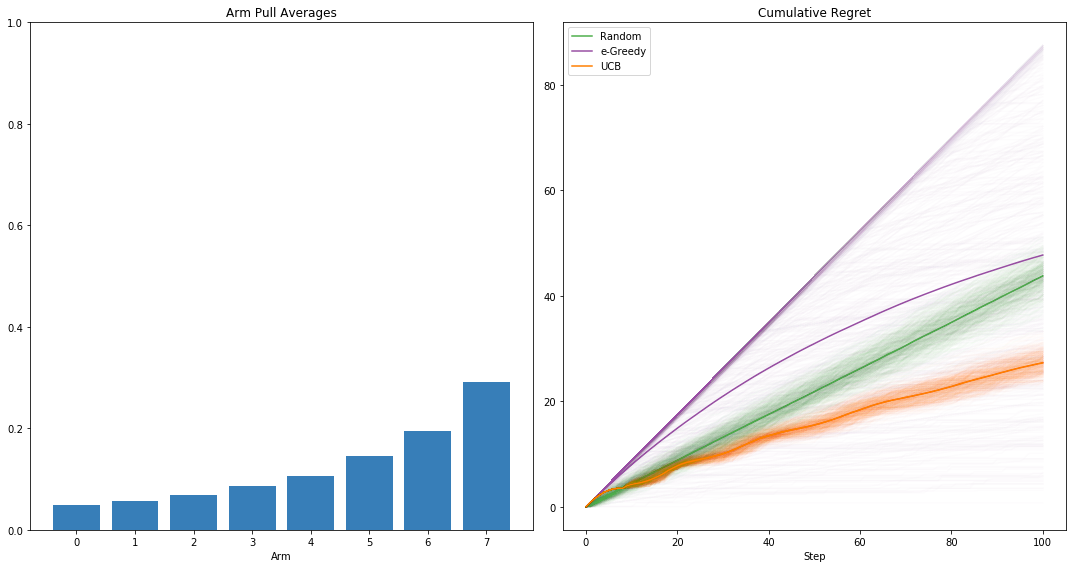

In [31]:
"""
UCB-1 action selection gives us a heuristic that works relatively well as long as the arm probabilities are not too close.
"""

def ucb_selection(env):
    ucb = np.sqrt((2 * np.log(env.visits.sum())) / env.visits)
    mod_avgs = env.arm_avgs() + ucb
    return np.argmax(mod_avgs)

ucb = run_simulation(ucb_selection, env, n_steps=n_steps, n_trials=n_trials)
plot_simulation([random[1], egreedy[1], ucb[1]], ucb[0], env)
plt.show()

## Contextual Bandits

The next class of environments we will look at are referred to as "Contexual" bandit problems. This refers to an observation we get to perform before choosing our action. The observation allows us to have "context" of the situation to use in choosing a useful action.

Examples of these types of problems are very common in recommender systems. We can think of a user having a context (or in a profile) that we can review before making a decision as to what ad we should serve or movie we can recommend.

In [ ]:
"""
Let's play around with a bandit to see what the problem is like. You can change any of the variables below
to modify how many arms there are or the likelihoods of arms giving reward. Once you run this cell, you will be 
able to interact with some buttons to produce plots on how well you are doing.
"""
n_arms = 8

n_arms = 2
n_states = 2

## Red: arm 1, Green: arm 0
state_probs = np.array([[0.1, 0.9], [0.9, 0.1]])
# state_probs = get_state_probs(n_states, n_arms)
config = {
    "num_arms" : n_arms,
    "num_states" : n_states,
    "state_probs": state_probs
}
env = ContextualBandit(config)

# Create fancy UI
buttons = [widgets.Button(description=f'Arm: {i}') for i in range(n_arms)]
cumulative_reward = [0]
def press(button):
    ## Sanitize inputs, clear current output
    clear_output()
    value = int(button.description.split(" ")[1])
    
    ## Step env, keep track of cumulative reward each step
    s, r = env.step(value)
    cumulative_reward.append(env.cumulative_reward.sum())

    # Use a colored box to show context
    if (s == 0):
        box = widgets.HTML(value="<div style='background-color: green ; padding: 10px; border: 1px solid green;'>")
    else: 
        box = widgets.HTML(value="<div style='background-color: red ; padding: 10px; border: 1px solid red;'>")
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 8))

    # State, action visitation
    action_norm = env.visits.sum(axis=1, keepdims=True)
    sns.heatmap(env.visits / action_norm, cmap="Blues", ax=axs[0], vmax=1, vmin=0, cbar=False, annot=True, xticklabels=np.arange(env.n_arms))
    axs[0].set_title("Arm averages")
    axs[0].set_ylabel("State/Context")
    axs[0].set_xlabel("Arm")
    axs[0].set_yticklabels(["Red", "Green"])

    plot_cumulative_reward(axs[1], cumulative_reward)
    
    cumulative_r = np.cumsum(env.regret)
    steps = np.arange(len(cumulative_r))
    axs[2].plot(steps, cumulative_r, label="You")
    axs[2].plot(steps, 0.8 * steps, label="Random")
    axs[2].set_title("Regret over time")
    
    fig.tight_layout()
    display(buttons)
    display(box)

[buttons[i].on_click(press) for i in range(n_arms)]
buttons = widgets.HBox(buttons)
display(buttons)

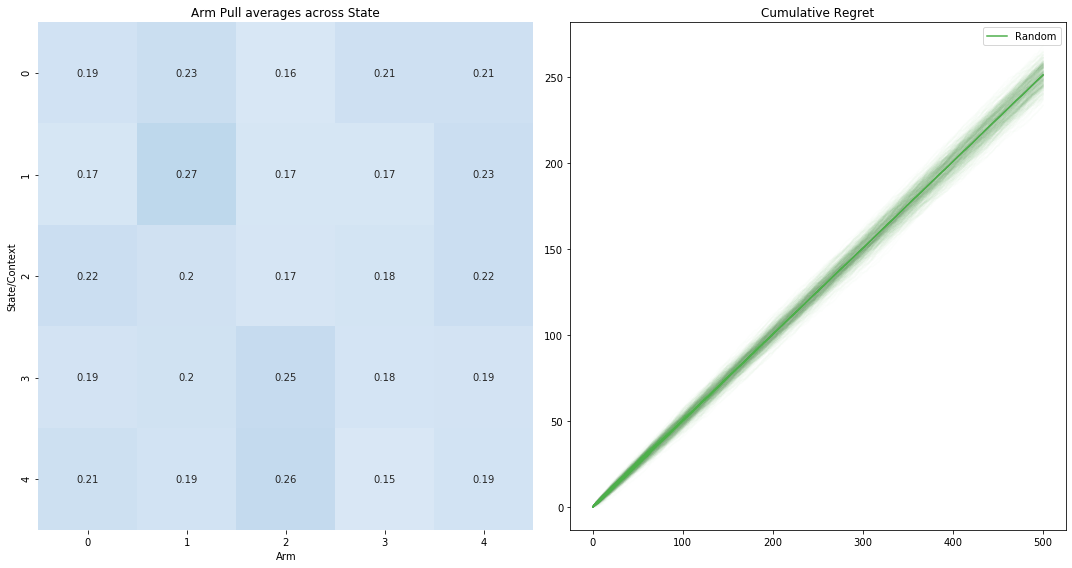

In [40]:
"""
Similar as before, using no exploitation gives good coverage across the state/action space.

Note: the heat map on the left is normalized by row to show what the pulls were across all states.
"""

n_steps = 100
n_trials = 500
n_arms = 5
n_states = 5

n_steps *= n_states # more states dilutes each interaction
# state_probs = np.array([[0.1, 0.9], [0.9, 0.1]])
state_probs = get_state_probs(n_states, n_arms)
config = {
    "num_arms" : n_arms,
    "num_states" : n_states,
    "state_probs": state_probs
}

env = ContextualBandit(config)
def random_selection(env):
    return np.random.randint(env.n_arms)

random = run_simulation(random_selection, env, n_steps=n_steps, n_trials=n_trials)
plot_contextual_simulation([random[1]], random[0], env)
plt.show()

In [41]:
"""
Similar to epsilon greedy as before, we keep track of the average rewards for each state for all the arms. 
We can then exploit this knowledge every so often dependent on the value of epsilon.
"""
def e_greedy_selection(env, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(env.n_arms)
    else:
        return np.argmax(env.arm_avgs(env.state))

def create_egreedy(epsilon):
    return lambda env: e_greedy_selection(env, epsilon)

def update(epsilon):
    global egreedy
    selection = create_egreedy(epsilon)
    egreedy = run_simulation(selection, env, n_steps=n_steps, n_trials=n_trials)
    plot_contextual_simulation([random[1], egreedy[1]], egreedy[0], env)
    plt.show()

interact_manual(update, epsilon=widgets.FloatSlider(min=0, max=1, step=0.05))

interactive(children=(FloatSlider(value=0.0, description='epsilon', max=1.0, step=0.05), Button(description='R…

<function __main__.update(epsilon)>

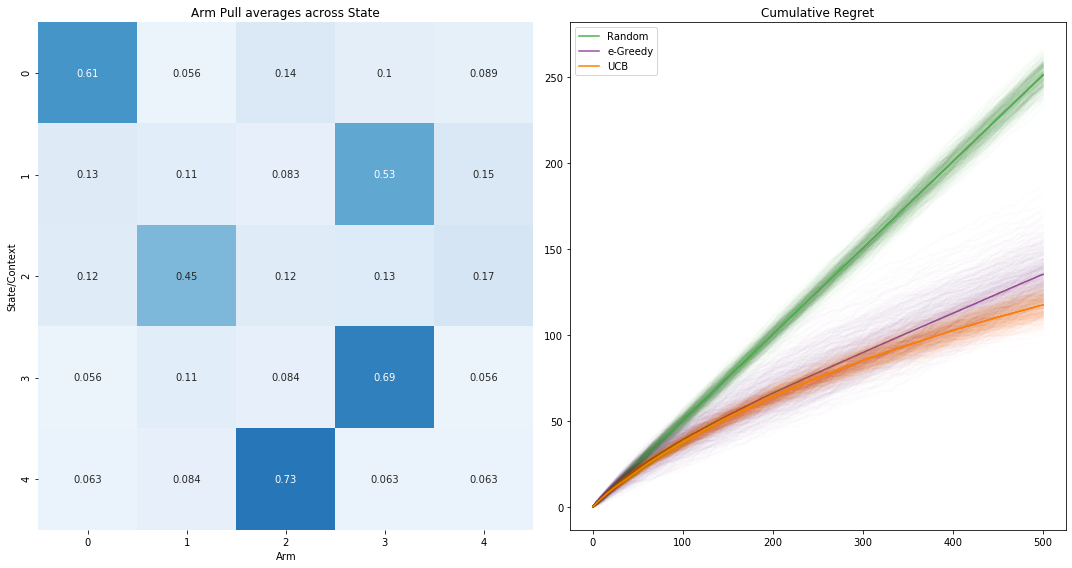

In [42]:
"""
As with the other solutions we can simply construct similar estimates as the standard bandit problem, but now stateful.
"""
def ucb_selection(env):
    ucb = np.sqrt((2 * np.log(env.visits[env.state, :].sum())) / env.visits[env.state, :])
    mod_avgs = env.arm_avgs(env.state) + ucb
    return np.argmax(mod_avgs)

ucb = run_simulation(ucb_selection, env, n_steps=n_steps, n_trials=n_trials)
plot_contextual_simulation([random[1], egreedy[1], ucb[1]], ucb[0], env)
plt.show()

# Modern Monte Carlo Tree Search

How can we efficiently search without relying on expert knowledge?

- **exploration**: learn values of actions we are uncertain about
- **exploitation**: focus search on promising parts of tree



## Markov Decision Processes (MDPs)

We have been building up the problem description in a more and more complex manner over the course of this presentation.

Our agents have only seen a state, took an action, and then recieved a reward for how they acted. There was no notion of time in any of these algorithms and so the agents actions had no effect on the future. Real decision making processes have some degree of effect on the payoff you get. We can model these systems with MDPs.

MDPs are a pretty general framework for dealing with decision making over some sort of horizon (possibly even infinite).



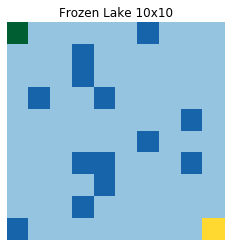

In [23]:
env = FrozenLakeEnv(10)
state = env.reset()
env.render()

## Value Functions

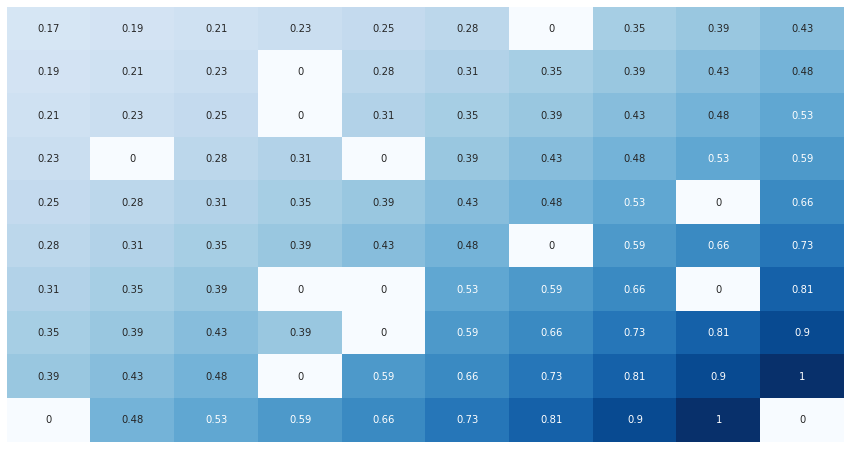

In [24]:
value_fcn = value_iteration(env, gamma=0.9)
plot_value_function(value_fcn, env)

Move DOWN
Visitations for each state during tree search: 


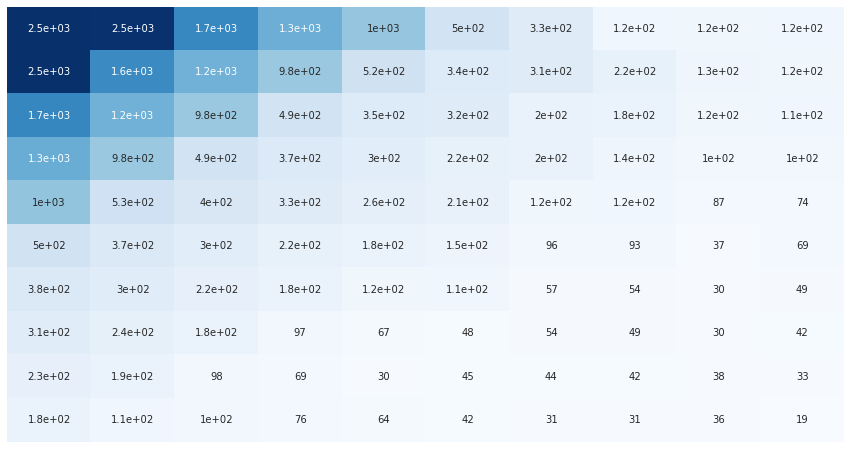

Value computed during tree search: 


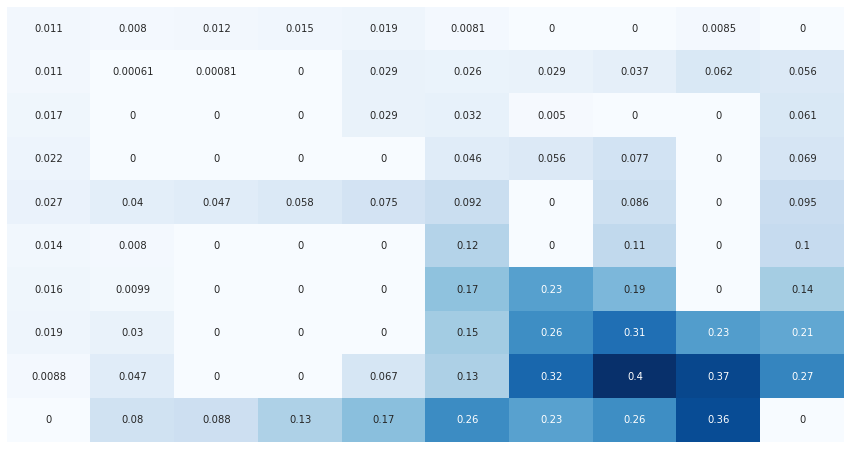

In [25]:
mcts = MCTS(env)
env.get_action(mcts.next_move(state))

print("Visitations for each state during tree search: ")
plot_value_function(mcts.visitation_fcn(), env)

print("Value computed during tree search: ")
plot_value_function(mcts.value_fcn(), env)

In [26]:
state = env.reset()
done = False

env.render()
steps = 0
while not done:
    mcts = MCTS(env)
    action = mcts.next_move(state)
    state, reward, done, _ = env.step(action)
    steps += 1

    env.render(save=True, ind=steps)
    # plot_value_function(mcts.value_fcn(), env)
    
create_gif("assets/frozen_lake/step_", steps)

print(f"Success! {steps} moves")

clear_output(wait=True)
plt.clf()
Image(url='assets/solution.gif')  

<Figure size 432x288 with 0 Axes>